# Project 3: Determining Posts' Subreddits

### Ethan Henley

## Problem Statement

To establish potential stakeholders, this model was designed for an **imaginary** client startup: LawChat, an app that intends to connect clients with legal experts on retainer to answer small-potatoes legal questions, preparing for a simultaneous soft launch in both the United States and the United Kingdom. 

LawChat cannot collect user location data. However, they wish to connect users to legal experts in the correct country. To facilitate this, we have decided to __generate a model to predict whether a legal advice request is coming from America or the United Kingdom based on the title and text of the message.__ 

We use posts from the subreddits r/legaladvice as a proxy for LawChat advice requests from the United States (though it allows posts from non-Americans) and r/LegalAdviceUK for the United Kingdom.

## Executive Summary

We used a Python script to access the PushShift API and gather data from the subreddits r/legaladvice and r/LegalAdviceUK, and saved that data to a .csv. This data includes post titles and bodies, which we used in our model. We gathered 3000 posts from each Subreddit.

We inspected and cleaned this data; accounting for deleted, removed, or otherwise blank posts; processed the text with stemming and word vectorization; and then ran multiple models.

Ultimately, we decided that, based on models' accuracy with testing data, our best model was a Multinomial Naive Bayes model. We were also interested in the concept of the Support Vector Machine model, though it was outperformed by the Multinomial Naive Bayes.

## Contents

- [Problem Statement](#Problem-Statement)
- [Executive Summary](#Executive-Summary)
- [Loading](#Loading)
- [Preliminary EDA](#Preliminary-EDA)
- [Data Cleaning](#Data-Cleaning)
    - [Imputing Nulls and Missing Values](#Imputing-Nulls-and-Missing-Values)
    - [Outliers in Numeric Columns](#Outliers-in-Numeric-Columns)
    - [Format Target](#Format-Target)
    - [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [EDA on Stemmed Word Vectors](#EDA-on-Stemmed-Word-Vectors)
    - [Count Vectorization EDA on Body](#Count-Vectorization-EDA-on-Body)
    - [Count Vectorization EDA on Title](#Count-Vectorization-EDA-on-Title)
    - [Count Vectorization EDA on Combined](#Count-Vectorization-EDA-on-Combined)
    - [Wordcount Caveat](#Wordcount-Caveat)
    - [TFIDF Vectorization EDA](#TFIDF-Vectorization-EDA)
- [Preprocessing](#Preprocessing)
- [Modeling](#Modeling)
    - [Baseline Model](#Baseline-Model)
    - [Logistic Regression Model](#Logistic-Regression-Model)
    - [Multinomial Naive Bayes Model](#Multinomial-Naive-Bayes-Model) *
    - [Gaussian Naive Bayes Model](#Gaussian-Naive-Bayes-Model)
    - [Support Vector Machine Model](#Support-Vector-Machine-Model)
    - [AdaBoost Model](#AdaBoost-Model)
    - [$k$-Nearest Neighbors Model](#$k$-Nearest-Neighbors-Model)
    - [Bagged Trees Model](#Bagged-Trees-Model)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)
- [Materials Used](#Materials-Used)

## Loading

Import relevant libraries, modules.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, \
    TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

import regex as re

import time

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

Read in the data, which was gathered using the Pushshift API for Reddit via the script `scraping.py`.

In [2]:
df = pd.read_csv('../data/scraped.csv')
orig_cols = df.columns

## Preliminary EDA

Quick look at some of the data.

In [3]:
df.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Balisong Knives in Canada,Is it illegal to keep a balisong knife in cana...,legaladvice,1577558639,HunterCTF,1,1,True,2019-12-28
1,Need advices don’t know where to go.,Need advices on my case\n\nLong story short i ...,legaladvice,1577558685,pinochioo,7,1,True,2019-12-28
2,AZ - Real Estate: mortgage not covering second...,I just realized when refinancing that I might ...,legaladvice,1577558733,clairvoiaynce,4,1,True,2019-12-28
3,Friend of mine from Australia,"So I friend of mine currently, living with a g...",legaladvice,1577559126,LordOstrik,2,1,True,2019-12-28
4,Retrieve Files from Webhost,I suppose I need a court order to obtain my fi...,legaladvice,1577559197,stahlgrau,3,1,True,2019-12-28


In [4]:
df.tail()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
5995,HR wants to fire me because I'm depressed,*Sorry in advance for the long post*\nI have s...,LegalAdviceUK,1565180205,theresajen,11,18,True,2019-08-07
5996,Co-worker withholding my tips.,"I worked on a bar, and left to move to a diffe...",LegalAdviceUK,1565180354,funnywittyusername1,2,3,True,2019-08-07
5997,Driveway ruined (continuation),This saga goes on.\n\nIn brief: driveway done ...,LegalAdviceUK,1565180557,unappealinghabits,7,3,True,2019-08-07
5998,Previous employer wants me to settle charges f...,I left my last job at in the first few days of...,LegalAdviceUK,1565181290,TAway7819,3,2,True,2019-08-07
5999,Do you have to transfer the ownership of a dec...,My stepdad passed away very suddenly a couple ...,LegalAdviceUK,1565181351,stubrador,4,2,True,2019-08-07


## Data Cleaning

### Imputing Nulls and Missing Values

Look at types and nulls.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
title           6000 non-null object
selftext        5930 non-null object
subreddit       6000 non-null object
created_utc     6000 non-null int64
author          6000 non-null object
num_comments    6000 non-null int64
score           6000 non-null int64
is_self         6000 non-null bool
timestamp       6000 non-null object
dtypes: bool(1), int64(3), object(5)
memory usage: 381.0+ KB


`selftext` has many nulls; these represent empty post bodies, and will be replaced with empty strings.

In [6]:
df.loc[df['selftext'].isnull(), 'selftext'] = ''

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
title           6000 non-null object
selftext        6000 non-null object
subreddit       6000 non-null object
created_utc     6000 non-null int64
author          6000 non-null object
num_comments    6000 non-null int64
score           6000 non-null int64
is_self         6000 non-null bool
timestamp       6000 non-null object
dtypes: bool(1), int64(3), object(5)
memory usage: 381.0+ KB


No more nulls. 

Any weird/recurring posts?

In [8]:
df['selftext'].value_counts()[:5]

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [9]:
df['title'].value_counts()[:5]

(NJ) Roofers used electrical outlet that was bad and caused minor siding damage and breaker to trip.    4
Pseudo-bank [Revolut] has frozen my last salary deposit. Possible actions?                              3
Punishment advice                                                                                       3
Going on 3 months' vacation. Can we pay mortgage 3 months in advance?                                   3
Please help                                                                                             2
Name: title, dtype: int64

Replace `'[removed]'` and `'[deleted]'` with an empty string as well.

In [10]:
df.loc[(df['selftext'] == '[removed]') | (df['selftext'] == '[deleted]'),
       'selftext'] = ''

We do not remove empty-bodied posts entirely, because their titles are still useful, and ideally our model will even have a prediction for an empty-bodied post.

There also are repeated, obviously human-written posts in the dataset; we dropped exact duplicates as a part of scraping, so these have some characteristics that vary. In the interest of including the potentially changed titles, we will leave these in.

### Outliers in Numeric Columns

Look for outliers.

In [11]:
df.describe()

,created_utc,num_comments,score
count,6.000000e+03,6000.000000,6000.000000
mean,1.571243e+09,8.022667,13.544833
std,4.443266e+06,11.591055,236.831469
min,1.564599e+09,0.000000,0.000000
25%,1.567250e+09,2.000000,1.000000
50%,1.571333e+09,5.000000,1.000000
75%,1.575053e+09,9.000000,2.000000
max,1.578236e+09,191.000000,13398.000000


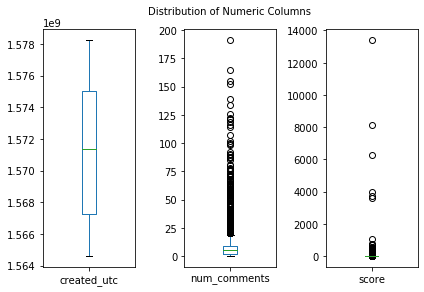

In [12]:
df.plot(kind='box', subplots=True)
plt.tight_layout()
plt.text(-1.425,1.5e4,'Distribution of Numeric Columns');
# for analysis only

There are outliers in `score` and `num_comments` that represent extremely popular posts. We aren't using these variables in our model, but outliers in those columns might be indicative of outliers in columns we are including.\
Still, these will be left in; in fact, we ideally would try to collect data containing more of these outliers to better account for popular posts, which are not terribly uncommon and which we might want to be recognizable by our model. However, because our problem statement is agnostic to most Reddit particularities, this will not be done.

### Format Target

Format target column; `0` for r/legaladvice, `1` for r/LegalAdviceUK.\
Because LegalAdviceUK is UK-specific while legaladvice is not strictly US-specific, we treat a UK-detection as our 'positive' outcome.

In [13]:
df['subreddit'] = df['subreddit'].map(lambda s: int(s=='LegalAdviceUK'))

## Exploratory Data Analysis

Is our data evenly distributed?

In [14]:
df['subreddit'].value_counts()

1    3000
0    3000
Name: subreddit, dtype: int64

### EDA on Stemmed Word Vectors

We're going to better tune our vectorization as part of modeling, but we can here perform lemmatization or stemming and look at some limited vectorization.

First, let's experiment with tokenization, stemming, and vectorization.

In [15]:
# remove non-letters
ex_str = re.sub('[^\w]', ' ', df['selftext'][0])

# instantiate a tokenizer
tokenizer = RegexpTokenizer(r'\w+\S+')

# instantiate a stemmer
p_stemmer = PorterStemmer()

# test the tokenizer+stemmer on the letters in a single text body
# and then recombine it back into a single string for vectorization
ex_str = ' '.join([p_stemmer.stem(token.lower()) 
                   for token in tokenizer.tokenize(ex_str)])

# perform untuned count vectorization on the example string
cvec = CountVectorizer()
ex_vec = cvec.fit_transform(pd.Series(data=[ex_str]))

pd.DataFrame(ex_vec.toarray(),columns=cvec.get_feature_names())

,all,and,at,balisong,but,can,canada,cant,carri,do,...,knife,look,onlin,public,that,them,to,trick,want,you
0,1,1,1,1,2,1,1,1,1,1,...,1,1,1,1,2,1,2,1,1,1


This process seems suitable. We'll apply it to the whole of the post data _for analysis only_. We will vectorize properly as a part of the modeling process.

### Count Vectorization EDA on Body

I want to look at straight wordcounts with count vectorization.

In [16]:
# a function to run a basic count vectorization with stemming
def basic_cvec(col):
    
    # remove non-letters, apply lowercase
    col = col.map(lambda s: re.sub('[^\w\s]','',s).lower())
    
    # instantiate tokenizer, stemmer
    tokenizer = RegexpTokenizer(r'\w+\S+') # only needed to format stemming
    p_stemmer = PorterStemmer()
    
    # generate stemmed stopwords
    stops = {p_stemmer.stem(w) for w in stop_words.ENGLISH_STOP_WORDS}
    
    # instantiate vectorizer
    cvec = CountVectorizer(max_features=100, stop_words=stops)
    
    # apply tokenizer and stemmer and then re-string
    col = col.map(lambda s: ' '.join([p_stemmer.stem(t)
                                      for t in tokenizer.tokenize(s)]))
    
    # return df of vectorized words
    return pd.DataFrame(cvec.fit_transform(col).toarray(),
                        columns=cvec.get_feature_names())

In [17]:
%time df_text_cvec = basic_cvec(df['selftext'])

Wall time: 19.2 s


In [18]:
df_basic_cvec = pd.concat((df[['title','selftext','subreddit']], 
                           df_text_cvec),axis='columns')
df_basic_cvec.head()

,title,selftext,subreddit,account,advic,ago,ask,away,car,case,...,time,told,tri,use,want,way,week,went,work,year
0,Balisong Knives in Canada,Is it illegal to keep a balisong knife in cana...,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,Need advices don’t know where to go.,Need advices on my case\n\nLong story short i ...,0,0,2,0,0,0,6,1,...,0,4,0,0,0,0,0,3,1,0
2,AZ - Real Estate: mortgage not covering second...,I just realized when refinancing that I might ...,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,Friend of mine from Australia,"So I friend of mine currently, living with a g...",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,Retrieve Files from Webhost,I suppose I need a court order to obtain my fi...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1


Count vectorizer has given raw word (actually stem) count. I am interested in what words appear most often overall.

In [19]:
print('combined')
df_basic_cvec.drop(['title','selftext','subreddit'], axis='columns'
                  ).sum().sort_values(ascending=False)

combined


im        4819
work      4026
just      3661
time      3434
want      3059
          ... 
reason     801
away       801
doesnt     789
chang      785
report     782
Length: 100, dtype: int64

Certain stems occurr in more than two thirds of the analyzed posts; 'im' (primarily representing 'I'm') and 'work.'

What about word occurrence by subreddit?

In [20]:
print('USA')

sum_basic_cvec = df_basic_cvec.drop(['title','selftext'], axis='columns'
                                  ).groupby('subreddit').sum()
sum_basic_cvec.loc[0].sort_values(ascending=False)

USA


im          2438
just        1974
work        1781
time        1745
want        1573
            ... 
reason       371
employ       362
contract     359
current      358
chang        341
Name: 0, Length: 100, dtype: int64

In [21]:
print('UK')
sum_basic_cvec.loc[1].sort_values(ascending=False)

UK


im        2381
work      2245
time      1689
just      1687
year      1590
          ... 
offic      383
insur      383
law        373
check      371
report     369
Name: 1, Length: 100, dtype: int64

I am interested in the gulf between the two subreddits, words that appear often in one but less often in the other. We will inspect that.

In [22]:
print('UK occurrence - USA occurrence')
diff=pd.DataFrame((
    sum_basic_cvec.T[1] - sum_basic_cvec.T[0]
).sort_values(ascending=False)).rename(columns={0:'UK - USA'})
diff

UK occurrence - USA occurrence


,UK - USA
contract,535
work,464
ive,395
properti,321
email,315
...,...
insur,-216
tri,-219
state,-268
live,-275


Even though 'just' occurs very often in both subreddits, it still is used more in America than Britain than any other word. Similarly, even though 'work' is in the three most common words for each subreddit's post bodies, it is the second 'most British word,' at least among those explored here.

We can inspect the words in our selection which were not especially more common in one subreddit than the other.

In [23]:
diff[abs(diff['UK - USA']) < df.shape[0]/200] # cap mostly arbitrary

,UK - USA
question,29
legal,25
point,24
doesnt,19
situat,8
realli,3
start,2
didnt,2
away,-11
place,-12


I might consider removing words of this sort as stopwords, as they occur with similar frequency across the two subreddits. However, they may be relevant if I model word groupings as well as single words, so they should not be excluded without analysis.

I want to visualize this for some of those words.

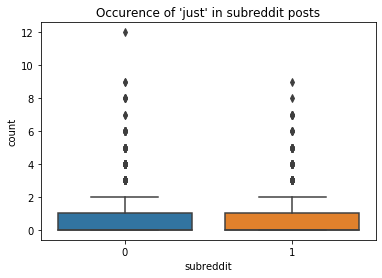

In [24]:
sns.boxplot(df_basic_cvec['subreddit'],df_basic_cvec['just'])
plt.title('Occurence of \'just\' in subreddit posts')
plt.ylabel('count');

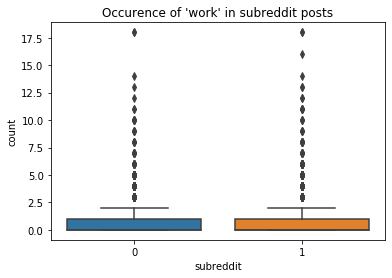

In [25]:
sns.boxplot(df_basic_cvec['subreddit'],df_basic_cvec['work'])
plt.title('Occurence of \'work\' in subreddit posts')
plt.ylabel('count');

im is primarily representative of I'm


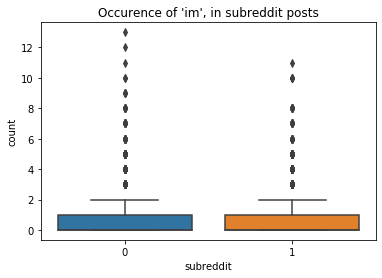

In [26]:
sns.boxplot(df_basic_cvec['subreddit'],df_basic_cvec['im'])
plt.title('Occurence of \'im\', in subreddit posts')
plt.ylabel('count');
print('im is primarily representative of I\'m')

### Count Vectorization EDA on Title

I also want to see this effect in the title columns.

In [27]:
%time df_text_cvec_t = basic_cvec(df['title'])
df_basic_cvec_t = pd.concat((df[['title','selftext','subreddit']], 
                             df_text_cvec_t),axis='columns')
print('combined')
df_basic_cvec_t.drop(['title','selftext','subreddit'], axis='columns'
                    ).sum().sort_values(ascending=False)

Wall time: 1.25 s
combined


legal     420
pay       348
car       324
work      307
employ    260
         ... 
dad        63
tenant     63
way        62
school     62
told       61
Length: 100, dtype: int64

In [28]:
print('USA')

sum_basic_cvec_t = df_basic_cvec_t.drop(
    ['title','selftext'], axis='columns').groupby('subreddit').sum()

sum_basic_cvec_t.loc[0].sort_values(ascending=False)

USA


legal      198
car        175
pay        163
need       117
work       114
          ... 
phone       22
drive       20
let         16
tenanc       5
england      1
Name: 0, Length: 100, dtype: int64

In [29]:
print('UK')
sum_basic_cvec_t.loc[1].sort_values(ascending=False)

UK


legal       222
work        193
pay         185
employ      168
car         149
           ... 
leas         18
neighbor     10
state         9
apart         8
ca            0
Name: 1, Length: 100, dtype: int64

In [30]:
print('UK occurrence - USA occurrence')
diff_t=pd.DataFrame((
    sum_basic_cvec_t.T[1] - sum_basic_cvec_t.T[0]
).sort_values(ascending=False)).rename(columns={0:'UK - USA'})
diff_t

UK occurrence - USA occurrence


,UK - USA
uk,105
england,86
work,79
employ,76
contract,74
...,...
got,-60
ca,-69
state,-71
apart,-74


'Work' is very British, despite showing up in the other titleset more than all but 4 words. Other words with big gaps, such as 'UK,' 'England,' 'CA,' and 'state' are obviously related to the geography of their posters. Non-Brits talk about 'apart,' a stem of 'apartment' and 'leas,' a stem of 'lease,' much more often; presumably, Brits are discussing flats, though no stem for it is apparent in these top 100.

We won't bother to visualize these; titles are much shorter than posts, so even the most common words don't appear in more than a quarter of the titles.

### Count Vectorization EDA on Combined

What about the combined text of the title and post?

In [31]:
%time df_text_cvec_2 = basic_cvec(df['title']+' '+df['selftext'])
df_basic_cvec_2 = pd.concat((df[['title','selftext','subreddit']], 
                             df_text_cvec_2),axis='columns')
print('combined')
df_basic_cvec_2.drop(['title','selftext','subreddit'], axis='columns'
                    ).sum().sort_values(ascending=False)

Wall time: 21.4 s
combined


im         5015
work       4333
just       3772
time       3540
pay        3344
           ... 
long        870
parent      858
away        851
current     850
report      845
Length: 100, dtype: int64

In [32]:
print('USA')

sum_basic_cvec_2 = df_basic_cvec_2.drop(
    ['title','selftext'], axis='columns').groupby('subreddit').sum()

sum_basic_cvec_2.loc[0].sort_values(ascending=False)

USA


im          2538
just        2046
work        1895
time        1804
want        1685
            ... 
long         409
sent         405
contract     401
chang        386
current      373
Name: 0, Length: 100, dtype: int64

In [33]:
print('UK')
sum_basic_cvec_2.loc[1].sort_values(ascending=False)

UK


im        2477
work      2438
pay       1774
time      1736
just      1726
          ... 
offic      404
report     396
check      391
parent     331
leas       122
Name: 1, Length: 100, dtype: int64

In [34]:
print('UK occurrence - USA occurrence')
diff_2=pd.DataFrame((
    sum_basic_cvec_2.T[1] - sum_basic_cvec_2.T[0]
).sort_values(ascending=False)).rename(columns={0:'UK - USA'})
diff_2

UK occurrence - USA occurrence


,UK - USA
contract,609
work,543
ive,409
advic,374
properti,344
...,...
insur,-223
live,-285
just,-320
state,-339


Brits are saying 'contract,' 'work,' 'I've,' and other words more and words like 'lease,' 'state,' and 'just (or justice)' less.

Let's see some of these counts compared.

In [35]:
def barpair_from_sum(sum_df, bar_words, proportional=False):
    # a function to format a sum df for sns barplotting
    # essentially, stacking two rows of a df onto each other
    # and adding a new subreddit column
    s = sum_df[bar_words].T
    s['words'] = s.index
    s0 = s[[0,'words']].rename(columns={0:'count'})
    s1 = s[[1,'words']].rename(columns={1:'count'})
    s0['subreddit'] = 'r/legaladvice'
    s1['subreddit'] = 'r/LegalAdviceUK'
    
    if proportional:
        s0['proportion'] = s0['count']/(s0['count']+s1['count'])
        s1['proportion'] = s1['count']/(s0['count']+s1['count'])
        sns.barplot(y='words',x='proportion',
                data=pd.concat([s0,s1]), hue='subreddit')
    else:
        sns.barplot(y='words',x='count',
                    data=pd.concat([s0,s1]), hue='subreddit')

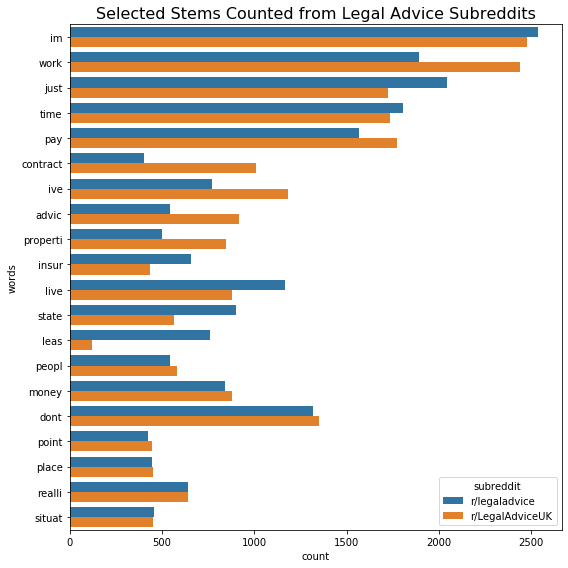

In [36]:
# some interesting words/stems
bar_words = ['im','work','just','time','pay',
             'contract','ive','advic','properti',
             'insur','live','state','leas',
             'peopl','money','dont','point',
             'place','realli','situat']

plt.figure(figsize=(8,8))
barpair_from_sum(sum_basic_cvec_2,bar_words)
plt.title('Selected Stems Counted from Legal Advice Subreddits',
          fontsize=16)
plt.tight_layout()

plt.savefig('../figures/bar.png')

We can visualize the 'gulf' better by plotting counts-in-subreddit/counts-overall.

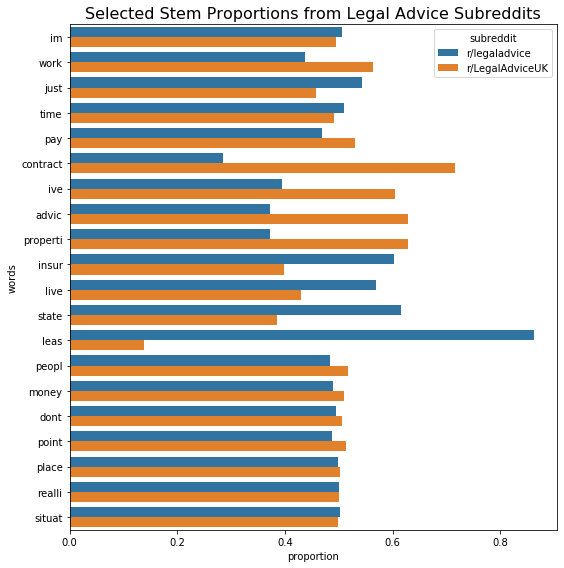

In [37]:
plt.figure(figsize=(8,8))
barpair_from_sum(sum_basic_cvec_2,bar_words,proportional=True)
plt.title('Selected Stem Proportions from Legal Advice Subreddits',
          fontsize=16)
plt.tight_layout()

plt.savefig('../figures/bar_prop.png')

The presence of some words whose appearance proportions are so dramatically titled toward one subreddit or the other is encouraging; it suggests that this methodology will indeed be useful in generating our intended model.

### Wordcount Caveat

There are some flaws with this approach. For one, word ocurrence is not scaled against the total wordcount for the subreddit corpora. Let's see if that should matter.

In [38]:
# avg wordcount per subreddit
usa_avg_words = ' '.join(
    [b for b in df.loc[df['subreddit']==0,'selftext']]
).count(' ')/df.loc[df['subreddit']==0,'selftext'].shape[0]

uk_avg_words = ' '.join(
    [b for b in df.loc[df['subreddit']==1,'selftext']]
).count(' ')/df.loc[df['subreddit']==1,'selftext'].shape[0]


print(usa_avg_words,'avg words in r/legaladvice posts')
print(uk_avg_words,'avg words in r/LegalAdviceUK posts')

201.51733333333334 avg words in r/legaladvice posts
205.00633333333334 avg words in r/LegalAdviceUK posts


There is a less than 2% difference in corpus wordcount. To account for this, we may want to consider a vectorizer other than CountVectorizer.

### TFIDF Vectorization EDA

Many of the most common words across the two subreddits are similar. I might want to use analysis less dependent on wordcount and more interested in unique words; I'll use term frequency-inverse document frequency vectorization for that.

In [39]:
# a function to run a basic TFIDF-vectorization with stemming
def basic_tvec(col):
    
    # remove non-letters, apply lowercase
#     col = col.map(lambda s: re.sub('[^\w]',' ',s).lower())
    col = col.map(lambda s: re.sub('[^\w\s]','',s).lower())
    
    # instantiate tokenizer, stemmer
    tokenizer = RegexpTokenizer(r'\w+\S+')
    p_stemmer = PorterStemmer()
    
    # generate stemmed stopwords
    stops = {p_stemmer.stem(w) for w in stop_words.ENGLISH_STOP_WORDS}
    
    # instantiate vectorizer
    tvec = TfidfVectorizer(max_features=100, stop_words=stops)
    
    # apply tokenizer and stemmer and then re-string
    col = col.map(lambda s: ' '.join([p_stemmer.stem(t)
                                      for t in tokenizer.tokenize(s)]))
    
    # return df of vectorized words
    return pd.DataFrame(tvec.fit_transform(col).toarray(),
                        columns=tvec.get_feature_names())

In [40]:
%time df_text_tvec = basic_tvec(df['selftext'])

Wall time: 19.8 s


In [41]:
df_basic_tvec = pd.concat((df[['title','selftext','subreddit']], 
                           df_text_tvec),axis='columns')
df_basic_tvec.head()

,title,selftext,subreddit,account,advic,ago,ask,away,car,case,...,time,told,tri,use,want,way,week,went,work,year
0,Balisong Knives in Canada,Is it illegal to keep a balisong knife in cana...,0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.00000,0.0,0.0,0.408798,0.000000,0.000000,0.000000,0.000000,0.000000
1,Need advices don’t know where to go.,Need advices on my case\n\nLong story short i ...,0,0.000000,0.180459,0.0,0.0,0.0,0.614282,0.102288,...,0.0,0.31943,0.0,0.0,0.000000,0.000000,0.000000,0.295991,0.071212,0.000000
2,AZ - Real Estate: mortgage not covering second...,I just realized when refinancing that I might ...,0,0.000000,0.152586,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.00000,0.0,0.0,0.119649,0.000000,0.000000,0.000000,0.000000,0.124254
3,Friend of mine from Australia,"So I friend of mine currently, living with a g...",0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.00000,0.0,0.0,0.128701,0.000000,0.000000,0.000000,0.000000,0.000000
4,Retrieve Files from Webhost,I suppose I need a court order to obtain my fi...,0,0.312042,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.257335,0.235214,0.000000,0.000000,0.206049


We will consider TFIDF vectorization an option during preprocessing and modeling. 

## Preprocessing

I should choose if I want to lemmatize or stem (or do neither to) my data; both are different ways of reducing words to simpler forms, so multiple forms with the same root can be treated the same.

This function will apply one or the other (or neither) to a column of strings.

In [42]:
# a function to tokenize, lemmatize/stem, and re-string a column of strings
# note that strings lemmatized or stemmed will no longer fully respond to
# unlemmatized/unstemmed stopwords
def lemstemnone(which, col):
    
    if which == None:
        which = 'None' # if statements expect which to be a string
        
    # remove non-letters, apply lowercase
    col = col.map(lambda s: re.sub('[^\w\s]','',s).lower())
    
    # instantiate tokenizer
    tokenizer = RegexpTokenizer(r'\w+\S+')
    
    if which.lower() == 'stem':
        # instantiate stemmer
        p_stemmer = PorterStemmer()
        # apply tokenizer and stemmer and then re-string
        col = col.map(lambda s: ' '.join([p_stemmer.stem(t)
                                          for t in tokenizer.tokenize(s)]))
        
    elif which.lower() == 'lem' or which.lower() == 'lemmatize':
        # instantiate lemmatizer
        lemmatizer = WordNetLemmatizer()
        # apply tokenizer and lemmatizer and then re-string
        col = col.map(lambda s: ' '.join([lemmatizer.lemmatize(t)
                                          for t in tokenizer.tokenize(s)]))
        
    else: # this section unnecessary, just for readability
        pass # still edited text; already removed non-letters & lowercased
    
    return col

We will use a stratified train/test split on the combined title and selftext, and then run different kinds of processing in pipelines as part of model selection. Our dataset is large enough that we are comfortable with the default .75/.25 split.

In [43]:
# lsn_which = 'lem' # lemmatize
lsn_which = 'stem' # stem

X = lemstemnone(lsn_which,df['title'] + ' ' + df['selftext']) # all text
y = df['subreddit']

seed = 1007
cv_times = 5

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    random_state=seed)

We will also apply the same lemmatization to a list of stopwords, so that they are appropriately removed.

In [44]:
stops = set(lemstemnone(lsn_which, 
                        pd.Series(list(stop_words.ENGLISH_STOP_WORDS))))

## Modeling

We will measure all our models' accuracy to determine their usefulness, as incorrect predictions in either direction are equally bad.

### Baseline Model

We will compare each model against other models and against a baseline that predicts `1`, or UK, for every input. 

In [45]:
# baseline
print('Daft Baseline')
print('Train Accuracy:',np.mean(y_train == 1))
print('Test Accuracy:',np.mean(y_test == 1))

Daft Baseline
Train Accuracy: 0.5
Test Accuracy: 0.5


Because we stratified and had equal representation in our dataset, the baseline accuracy is exactly .5 for both the training data and the test data. This is, in a way, the absolute worst model possible; for binary classification, any model with < .5 accuracy could simply be inverted to beat .5 accuracy.

### Logistic Regression Model

Often logistic regression is more useful for interpretability than prediction, but it is worth attempting on our text. We will use LASSO regularization to assist with feature selection, since we have at least 1000 potential features. We use TFIDF vectorizer because it is scaled, which is useful for regularized data.

We will need to convert the sparse array of TfidfVectorizer to an ordinary array in the pipeline.

In [46]:
class Desparse:
    def fit(self, *args):
        return self
    def transform(self, arr):
        try:
            return arr.toarray()
        except:
            print('Not sparse!')
            return arr

In [47]:
pipe_tvec_lr_params = {
    'vec__ngram_range':((1,1),(1,2)),
    'vec__stop_words':(None,stops),
    'vec__max_features':(1000,5000),
    'lr__C':np.logspace(-1.5,-.5,9)
}
pipe_tvec_lr = Pipeline([
    ('vec', TfidfVectorizer()),
    ('desparse', Desparse()),
    ('lr', LogisticRegression(penalty='l1',solver='liblinear'))
])


gs_tvec_lr = GridSearchCV(pipe_tvec_lr, pipe_tvec_lr_params, cv=cv_times)
%time gs_tvec_lr.fit(X_train, y_train)
model_tvec_lr = gs_tvec_lr.best_estimator_

Wall time: 7min 36s


In [48]:
gs_tvec_lr.best_params_

{'lr__C': 0.31622776601683794,
 'vec__max_features': 1000,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': {'',
  'about',
  'abov',
  'across',
  'after',
  'afterward',
  'again',
  'against',
  'all',
  'almost',
  'alon',
  'along',
  'alreadi',
  'also',
  'although',
  'alway',
  'am',
  'among',
  'amongst',
  'amoungst',
  'amount',
  'an',
  'and',
  'ani',
  'anoth',
  'anyhow',
  'anyon',
  'anyth',
  'anyway',
  'anywher',
  'are',
  'around',
  'as',
  'at',
  'back',
  'be',
  'becam',
  'becaus',
  'becom',
  'been',
  'befor',
  'beforehand',
  'behind',
  'below',
  'besid',
  'between',
  'beyond',
  'bill',
  'both',
  'bottom',
  'but',
  'by',
  'call',
  'can',
  'cannot',
  'cant',
  'co',
  'con',
  'could',
  'couldnt',
  'cri',
  'de',
  'describ',
  'detail',
  'do',
  'done',
  'down',
  'due',
  'dure',
  'each',
  'eg',
  'eight',
  'either',
  'eleven',
  'els',
  'elsewher',
  'empti',
  'enough',
  'etc',
  'even',
  'ever',
  'everi',
  'everyon',
  '

In [49]:
print('TfidfVectorizer & Logistic Regression')
print('Train Accuracy:',
      model_tvec_lr.score(X_train, y_train))
print('Test Accuracy:',
      model_tvec_lr.score(X_test, y_test))

TfidfVectorizer & Logistic Regression
Train Accuracy: 0.8022222222222222
Test Accuracy: 0.7673333333333333


The logistic regression outperformed our baseline, but left much to be desired, as it suffered from some bias. It was not, however, too seriously overfit.

In [50]:
yh_test = model_tvec_lr.predict(X_test)
confusion_matrix(y_test, yh_test)

#    pf pt
# af tn fp
# at fn tp

array([[641, 109],
       [240, 510]], dtype=int64)

The logistic regression was more likely to predict a post to be non-UK than to be UK. 

### Multinomial Naive Bayes Model

Naive Bayes is a type of classification model that assumes all features are independent of one another. This assumption is almost certainly untrue for our data, but the model may still prove useful. Naive Bayes are also known to perform well on natural language data.

A multinomial Naive Bayes is appropriate for count vectorized data. We will implement it on the text. 

In [51]:
pipe_cvec_bayes_params = {
    'vec__ngram_range':((1,1),(1,2)),
    'vec__stop_words':(None,stops),
    'vec__max_features':(1000,5000),
    'bayes__alpha':np.logspace(-3,0,4)
}

pipe_cvec_bayes = Pipeline([
    ('vec', CountVectorizer()),
    ('bayes', MultinomialNB())
])


gs_cvec_bayes = GridSearchCV(pipe_cvec_bayes, pipe_cvec_bayes_params, 
                             cv=cv_times)
%time gs_cvec_bayes.fit(X_train, y_train)
model_cvec_bayes = gs_cvec_bayes.best_estimator_

Wall time: 3min 7s


In [52]:
gs_cvec_bayes.best_params_

{'bayes__alpha': 0.01,
 'vec__max_features': 5000,
 'vec__ngram_range': (1, 2),
 'vec__stop_words': {'',
  'about',
  'abov',
  'across',
  'after',
  'afterward',
  'again',
  'against',
  'all',
  'almost',
  'alon',
  'along',
  'alreadi',
  'also',
  'although',
  'alway',
  'am',
  'among',
  'amongst',
  'amoungst',
  'amount',
  'an',
  'and',
  'ani',
  'anoth',
  'anyhow',
  'anyon',
  'anyth',
  'anyway',
  'anywher',
  'are',
  'around',
  'as',
  'at',
  'back',
  'be',
  'becam',
  'becaus',
  'becom',
  'been',
  'befor',
  'beforehand',
  'behind',
  'below',
  'besid',
  'between',
  'beyond',
  'bill',
  'both',
  'bottom',
  'but',
  'by',
  'call',
  'can',
  'cannot',
  'cant',
  'co',
  'con',
  'could',
  'couldnt',
  'cri',
  'de',
  'describ',
  'detail',
  'do',
  'done',
  'down',
  'due',
  'dure',
  'each',
  'eg',
  'eight',
  'either',
  'eleven',
  'els',
  'elsewher',
  'empti',
  'enough',
  'etc',
  'even',
  'ever',
  'everi',
  'everyon',
  'everyth'

In [53]:
print('CountVectorizer & Naive Bayes')
print('Train Accuracy:',
      model_cvec_bayes.score(X_train, y_train))
print('Test Accuracy:',
      model_cvec_bayes.score(X_test, y_test))

CountVectorizer & Naive Bayes
Train Accuracy: 0.9075555555555556
Test Accuracy: 0.8526666666666667


This Multinomial Naive Bayes model was quite successful, reaching 85% accuracy. Variance is non-zero, but the model was good.

In [54]:
yh_test = model_cvec_bayes.predict(X_test)
yh_final = yh_test
confusion_matrix(y_test, yh_test)

#    pf pt
# af tn fp
# at fn tp

array([[655,  95],
       [126, 624]], dtype=int64)

This model was somewhat more likely to predict non-UK than UK, but not to the same degree as the logistic regression.

### Gaussian Naive Bayes Model

A Gaussian Naive Bayes is appropriate for TFIDF vectorized data. We will implement it on the text.

In [55]:
pipe_tvec_bayes_params = {
    'vec__ngram_range':((1,1),(1,2)),
    'vec__stop_words':(None,stops),
    'vec__max_features':(500,1000,5000)
}

pipe_tvec_bayes = Pipeline([
    ('vec', TfidfVectorizer()),
    ('desparse', Desparse()),
    ('bayes', GaussianNB())
])


gs_tvec_bayes = GridSearchCV(pipe_tvec_bayes, pipe_tvec_bayes_params, 
                             cv=cv_times)
%time gs_tvec_bayes.fit(X_train, y_train)
model_tvec_bayes = gs_tvec_bayes.best_estimator_

Wall time: 1min 28s


In [56]:
gs_tvec_bayes.best_params_

{'vec__max_features': 5000,
 'vec__ngram_range': (1, 2),
 'vec__stop_words': None}

In [57]:
print('TfidfVectorizer & Naive Bayes')
print('Train Accuracy:',
      model_tvec_bayes.score(X_train, y_train))
print('Test Accuracy:',
      model_tvec_bayes.score(X_test, y_test))

TfidfVectorizer & Naive Bayes
Train Accuracy: 0.9186666666666666
Test Accuracy: 0.8093333333333333


This Gaussian Naive Bayes model was more overfit than the Multinomial Naive Bayes model, and had a lower test accuracy.

In [58]:
yh_test = model_tvec_bayes.predict(X_test)
confusion_matrix(y_test, yh_test)
#    pf pt
# af tn fp
# at fn tp

array([[594, 156],
       [130, 620]], dtype=int64)

This model was somewhat more likely to predict UK.

### Support Vector Machine Model

A SVM 'draws' a 'line' across a warped version of our data that attempts to separate our different classes. It requires scaled data.

In [59]:
pipe_tvec_svm_params = {
    'vec__ngram_range':((1,1),(1,2),(2,2)),
    'svm__C':np.linspace(1.5,1.8,7)
}

pipe_tvec_svm = Pipeline([
    ('vec', TfidfVectorizer(max_features=1000, 
                            stop_words=stops)),
    ('desparse',Desparse()),
    ('svm', SVC(kernel='rbf',
                gamma='scale',
                max_iter=1e4))
])


gs_tvec_svm = GridSearchCV(pipe_tvec_svm, pipe_tvec_svm_params, 
                           cv=cv_times)
%time gs_tvec_svm.fit(X_train, y_train)
model_tvec_svm = gs_tvec_svm.best_estimator_

Wall time: 34min 19s


In [60]:
gs_tvec_svm.best_params_

{'svm__C': 1.65, 'vec__ngram_range': (1, 1)}

In [61]:
print('TfidfVectorizer & Support Vector Machine')
print('Train Accuracy:',
      model_tvec_svm.score(X_train, y_train))
print('Test Accuracy:',
      model_tvec_svm.score(X_test, y_test))

TfidfVectorizer & Support Vector Machine
Train Accuracy: 0.992
Test Accuracy: 0.8266666666666667


The SVM performed fairly well, with 83% accuracy on the test data. It was, however, very overfit, with notable variance. 

In [62]:
yh_test = model_tvec_svm.predict(X_test)
confusion_matrix(y_test, yh_test)

#    pf pt
# af tn fp
# at fn tp

array([[633, 117],
       [143, 607]], dtype=int64)

The SVM was somewhat more likely to predict non-UK.

### AdaBoost Model

AdaBoost is a boosting model based on the principles of stumped decision trees. It continually improves its model with each iteration.

In [63]:
pipe_cvec_abc_params = {
    'vec__ngram_range':((1,1),(1,2)),
    'vec__stop_words':(None,stops),
    'vec__max_features':[500,1000],
    'abc__n_estimators':(100,500)
}

pipe_cvec_abc = Pipeline([
    ('vec', CountVectorizer()),
    ('abc', AdaBoostClassifier())
])


gs_cvec_abc = GridSearchCV(pipe_cvec_abc, pipe_cvec_abc_params, 
                           cv=cv_times)
%time gs_cvec_abc.fit(X_train, y_train)
model_cvec_abc = gs_cvec_abc.best_estimator_

Wall time: 6min 12s


In [64]:
gs_cvec_abc.best_params_

{'abc__n_estimators': 500,
 'vec__max_features': 1000,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': {'',
  'about',
  'abov',
  'across',
  'after',
  'afterward',
  'again',
  'against',
  'all',
  'almost',
  'alon',
  'along',
  'alreadi',
  'also',
  'although',
  'alway',
  'am',
  'among',
  'amongst',
  'amoungst',
  'amount',
  'an',
  'and',
  'ani',
  'anoth',
  'anyhow',
  'anyon',
  'anyth',
  'anyway',
  'anywher',
  'are',
  'around',
  'as',
  'at',
  'back',
  'be',
  'becam',
  'becaus',
  'becom',
  'been',
  'befor',
  'beforehand',
  'behind',
  'below',
  'besid',
  'between',
  'beyond',
  'bill',
  'both',
  'bottom',
  'but',
  'by',
  'call',
  'can',
  'cannot',
  'cant',
  'co',
  'con',
  'could',
  'couldnt',
  'cri',
  'de',
  'describ',
  'detail',
  'do',
  'done',
  'down',
  'due',
  'dure',
  'each',
  'eg',
  'eight',
  'either',
  'eleven',
  'els',
  'elsewher',
  'empti',
  'enough',
  'etc',
  'even',
  'ever',
  'everi',
  'everyon',
  'ever

In [65]:
print('CountVectorizer & AdaBoost')
print('Train Accuracy:',
      model_cvec_abc.score(X_train, y_train))
print('Test Accuracy:',
      model_cvec_abc.score(X_test, y_test))

CountVectorizer & AdaBoost
Train Accuracy: 0.9315555555555556
Test Accuracy: 0.8006666666666666


AdaBoost performed fairly well, with a test accuracy of about 80%. Variance was not high, though bias held it back.

In [66]:
yh_test = model_cvec_abc.predict(X_test)
confusion_matrix(y_test, yh_test)

#    pf pt
# af tn fp
# at fn tp

array([[615, 135],
       [164, 586]], dtype=int64)

AdaBoost, like most but not all of our models, was more likely to predict non-UK.

### $k$-Nearest Neighbors Model

A kNN model predicts a datum's class based on its 'distance' to other points of other classes. In our context, that 'distance' is in a many-dimensional wordspace which ought to be scaled.

In [67]:
pipe_tvec_knn_params = {
    'vec__ngram_range':((1,1),(1,2)),
    'vec__stop_words':(None,stops),
    'vec__max_features':[500,1000],
    'knn__n_neighbors':(5, 21)
}

pipe_tvec_knn = Pipeline([
    ('vec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])


gs_tvec_knn = GridSearchCV(pipe_tvec_knn, pipe_tvec_knn_params, 
                           cv=cv_times)
%time gs_tvec_knn.fit(X_train, y_train)
model_tvec_knn = gs_tvec_knn.best_estimator_

Wall time: 1min 48s


In [68]:
gs_tvec_knn.best_params_

{'knn__n_neighbors': 21,
 'vec__max_features': 1000,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': {'',
  'about',
  'abov',
  'across',
  'after',
  'afterward',
  'again',
  'against',
  'all',
  'almost',
  'alon',
  'along',
  'alreadi',
  'also',
  'although',
  'alway',
  'am',
  'among',
  'amongst',
  'amoungst',
  'amount',
  'an',
  'and',
  'ani',
  'anoth',
  'anyhow',
  'anyon',
  'anyth',
  'anyway',
  'anywher',
  'are',
  'around',
  'as',
  'at',
  'back',
  'be',
  'becam',
  'becaus',
  'becom',
  'been',
  'befor',
  'beforehand',
  'behind',
  'below',
  'besid',
  'between',
  'beyond',
  'bill',
  'both',
  'bottom',
  'but',
  'by',
  'call',
  'can',
  'cannot',
  'cant',
  'co',
  'con',
  'could',
  'couldnt',
  'cri',
  'de',
  'describ',
  'detail',
  'do',
  'done',
  'down',
  'due',
  'dure',
  'each',
  'eg',
  'eight',
  'either',
  'eleven',
  'els',
  'elsewher',
  'empti',
  'enough',
  'etc',
  'even',
  'ever',
  'everi',
  'everyon',
  'everyt

In [69]:
print('TFIDF Vectorizer & k-Nearest Neighbors')
print('Train Accuracy:',
      model_tvec_knn.score(X_train, y_train))
print('Test Accuracy:',
      model_tvec_knn.score(X_test, y_test))

TFIDF Vectorizer & k-Nearest Neighbors
Train Accuracy: 0.7662222222222222
Test Accuracy: 0.706


The kNN model did not perform well, with a test accuracy worse than even that of the logistic regression. 

In [70]:
yh_test = model_tvec_knn.predict(X_test)
confusion_matrix(y_test, yh_test)

#    pf pt
# af tn fp
# at fn tp

array([[574, 176],
       [265, 485]], dtype=int64)

This model was drastically more likely to predict non-UK.

###  Bagged Trees Model

A bagging ensemble model runs numerous models on bootstraps and then aggregates their independent predictions. We will use a bagging model based on decision trees.

In [71]:
pipe_cvec_bdt_params = {
    'vec__ngram_range':((1,1),(1,2)),
    'vec__stop_words':(None,stops),
    'vec__max_features': [500,1000],
    'bdt__n_estimators': [10]
}

pipe_cvec_bdt = Pipeline([
    ('vec', CountVectorizer()),
    ('bdt', BaggingClassifier(n_jobs=-2))
])


gs_cvec_bdt = GridSearchCV(pipe_cvec_bdt, pipe_cvec_bdt_params, 
                           cv=cv_times)
%time gs_cvec_bdt.fit(X_train, y_train)
model_cvec_bdt = gs_cvec_bdt.best_estimator_

Wall time: 1min 50s


In [72]:
gs_cvec_bdt.best_params_

{'bdt__n_estimators': 10,
 'vec__max_features': 1000,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': {'',
  'about',
  'abov',
  'across',
  'after',
  'afterward',
  'again',
  'against',
  'all',
  'almost',
  'alon',
  'along',
  'alreadi',
  'also',
  'although',
  'alway',
  'am',
  'among',
  'amongst',
  'amoungst',
  'amount',
  'an',
  'and',
  'ani',
  'anoth',
  'anyhow',
  'anyon',
  'anyth',
  'anyway',
  'anywher',
  'are',
  'around',
  'as',
  'at',
  'back',
  'be',
  'becam',
  'becaus',
  'becom',
  'been',
  'befor',
  'beforehand',
  'behind',
  'below',
  'besid',
  'between',
  'beyond',
  'bill',
  'both',
  'bottom',
  'but',
  'by',
  'call',
  'can',
  'cannot',
  'cant',
  'co',
  'con',
  'could',
  'couldnt',
  'cri',
  'de',
  'describ',
  'detail',
  'do',
  'done',
  'down',
  'due',
  'dure',
  'each',
  'eg',
  'eight',
  'either',
  'eleven',
  'els',
  'elsewher',
  'empti',
  'enough',
  'etc',
  'even',
  'ever',
  'everi',
  'everyon',
  'every

In [73]:
print('CountVectorizer & Bagged Decision Trees')
print('Train Accuracy:',
      model_cvec_bdt.score(X_train, y_train))
print('Test Accuracy:',
      model_cvec_bdt.score(X_test, y_test))

CountVectorizer & Bagged Decision Trees
Train Accuracy: 0.984
Test Accuracy: 0.7573333333333333


The Bagged Decision Trees model underperformed, with an accuracy of about 76%, and was very overfit.

In [74]:
yh_test = model_cvec_bdt.predict(X_test)
confusion_matrix(y_test, yh_test)

#    pf pt
# af tn fp
# at fn tp

array([[622, 128],
       [236, 514]], dtype=int64)

This model was more likely to predict non-UK.

## Model Selection

|Model|Vectorizer|Train Accuracy|Test Accuracy|
|-|-|-|-|
|Baseline|n/a|.5|.5|
|Logistic Regression|TFIDF|.802|.767|
|Multinomial Naive Bayes|Count|.907|.853|
|Gaussian Naive Bayes|TFIDF|.919|.809|
|Support Vector Machine|TFIDF|.992|.827|
|AdaBoost|Count|.932|.801|
|kNN|TFIDF|.766|.706|
|Bagged Decision Trees|Count|.984|.757|

Based on test accuracy scores alone, it is easy to pick our best model: the Multinomial Naive Bayes. Knowledge that Naive Bayes models are generally suited well for natural language processing also influences this decision, even though we know that the naive assumption of variable independence absolutely does not hold for word counts.

The Support Vector Machine is interesting, and takes second place in test accuracy even as it is substantially overfit. Its usefulness on natural language data is worth remembering.

## Model Evaluation

In [75]:
print('CountVectorizer & Naive Bayes')
print('Train Accuracy:',
      model_cvec_bayes.score(X_train, y_train))
print('Test Accuracy:',
      model_cvec_bayes.score(X_test, y_test))
print('Test ROC AUC:', roc_auc_score(
    y_test, model_cvec_bayes.predict_proba(X_test)[:,1]))

CountVectorizer & Naive Bayes
Train Accuracy: 0.9075555555555556
Test Accuracy: 0.8526666666666667
Test ROC AUC: 0.9260453333333333


The Multinomial Naive Bayes model has a respectable, though far from perfect, 85% accuracy on test data. It also has an ROC AUC of 93%, suggesting that its probability predictions are of useful quality. It was not designed to be inferential, but it is an effective predictor.

In [76]:
confusion_matrix(y_test, yh_final)
#    pf pt
# af tn fp
# at fn tp

array([[655,  95],
       [126, 624]], dtype=int64)

Curiously, almost every model, including the Multinomial Naive Bayes, was more likely to predict r/legaladvice than r/LegalAdviceUK on a test set in which the two were evenly split. Perhaps this is partly because r/legaladvice is a general forum that likely includes some British posters who did not know to go to the UK-specific forum.

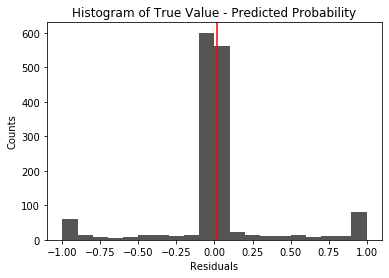

In [77]:
# residuals plot
yh_probs = model_cvec_bayes.predict_proba(X_test)[:,1]
plt.hist(y_test-yh_probs,color='#555555',bins=20) # hist
plt.axvline(np.mean(y_test-yh_probs),c='r') #mean
plt.xlabel('Residuals')
plt.ylabel('Counts')
plt.title('Histogram of True Value - Predicted Probability')
plt.savefig('../figures/residuals.png');

'Residuals' as a concept are different for this categorical predictor than they would be for a continuous regressor. This plot mainly only shows that most predicted probabilities were close to either 0 or 1.

## Conclusions and Recommendations

The best of the models we tested is the Multinomial Naive Bayes model, with 85% accuracy on non-training data. We expect this will extend to similar, non-Reddit data collected by LawChat, allowing the service to distinguish between UK and US users. 

This model could be upgraded after the hypothetical app's launch by retraining it on legitimate app data, which will hopefully remove some of the weaknesses that come from relying on Reddit data. 

However, 85% accuracy is far from perfect, so we would recommend that each legal expert respondent confirm that the messages forwarded to them appear to be from the correct country and be given an easy method to mark a message as for another country based on their judgement, which we expect they will need to do 15% of the time. Still, this is cheaper and preferable to having humans manually sort through every message.

Additionally, we would recommend that once location data can be easily and legally collected, which is much simpler and more accurate. Text-analysis-predicted locations could be used for the few cases where that is not feasible.

## Materials Used

- [Pushshift API](https://pushshift.io/)
- [r/legaladvice](https://reddit.com/r/legaladvice)
- [r/LegalAdviceUK](https://reddit.com/r/LegalAdviceUK)